# Exercise 2

## Q1

As detailed in the course, the formulation is close to the dual formulation of Wasserstein distance of order 1

## Q2

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torch.autograd as autograd

In [2]:
nb_samples = 10000
radius = 1
nz = .1
X_train = torch.zeros(( nb_samples , 2))
r = radius + nz*torch.randn(nb_samples)
theta = torch.rand(nb_samples)*2* torch.pi
X_train[:, 0] = r*torch.cos(theta)
X_train[:, 1] = r*torch.sin(theta)

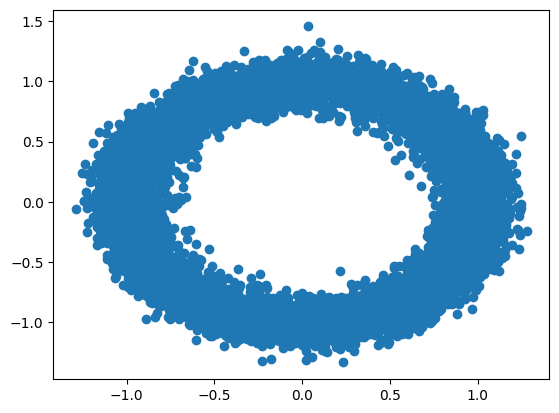

In [3]:
plt.scatter(X_train[:, 0],X_train[:, 1])
plt.show()

That is $p_{\text{data}}$ our target distribution.

## Q3

$G_\theta$ takes as input a vector of dimension $d$ the latent space, and outputs a vector of dimension 2 (same as the data).

$D_\beta$ takes a vector of dimension 2, and outputs a scalar of dimension 1.

## Q4

In [4]:
class Generator(nn.Module):
    def __init__(self , noise_dim =10):
        super(Generator , self).__init__ ()
        self.noise_dim = noise_dim
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2),

        )
    def forward(self , z):
        return self.model(z)# to complete

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator , self).__init__ ()
        self.model = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )
    def forward(self , x):
        return self.model(x)# to complete

In [5]:
def generate_images(generator_model , noise_dim , num_samples =1000):
    with torch.no_grad ():
        z = torch.Tensor(np.random.normal(0, 1, (num_samples , noise_dim)))
        predicted_samples = generator_model(z.type(torch.float32))
    plt.figure(figsize =(6, 6))
    plt.scatter(X_train[:, 0], X_train[:, 1], s=40, alpha =0.2,
    edgecolor='k', marker='+', label='original␣samples ')
    plt.scatter(predicted_samples [:, 0], predicted_samples [:, 1], s=10,
    alpha =0.9, c='r', edgecolor='k', marker='o', label='predicted '
    )
    plt.grid(alpha =0.5)
    plt.legend(loc='best')
    plt.tight_layout ()
    plt.show()

## Q5

The goal of clipping is to enforce the lip condition.

Epoch:␣ 0


<ipython-input-5-c18b4a8bd520>:6: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_train[:, 0], X_train[:, 1], s=40, alpha =0.2,


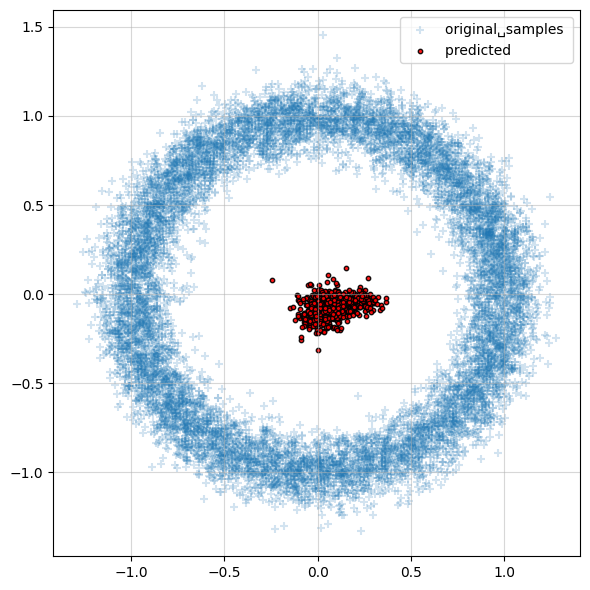

Epoch:␣ 50


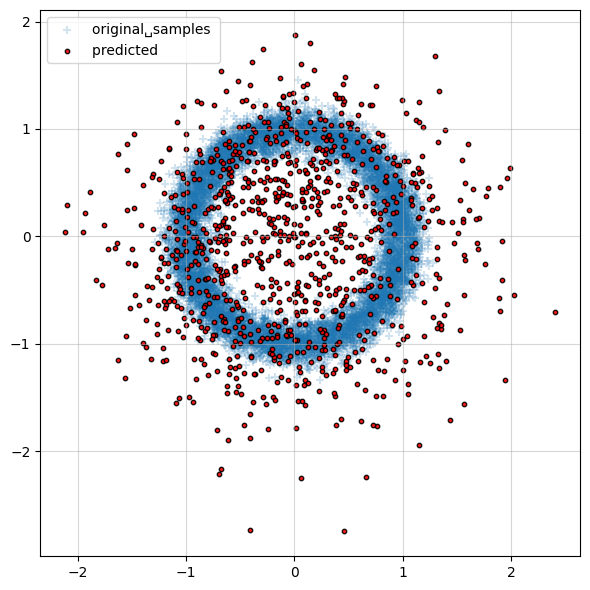

Epoch:␣ 100


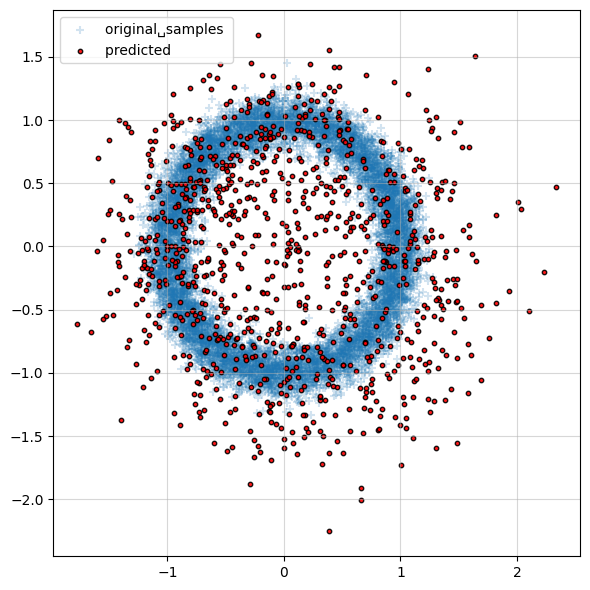

Epoch:␣ 150


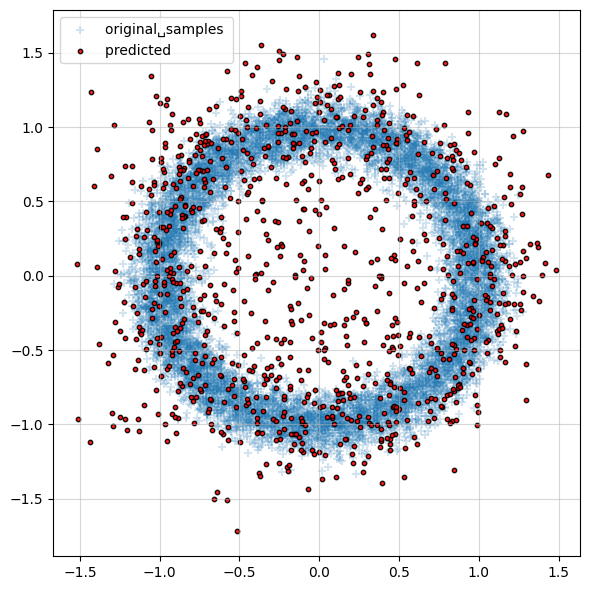

Epoch:␣ 200


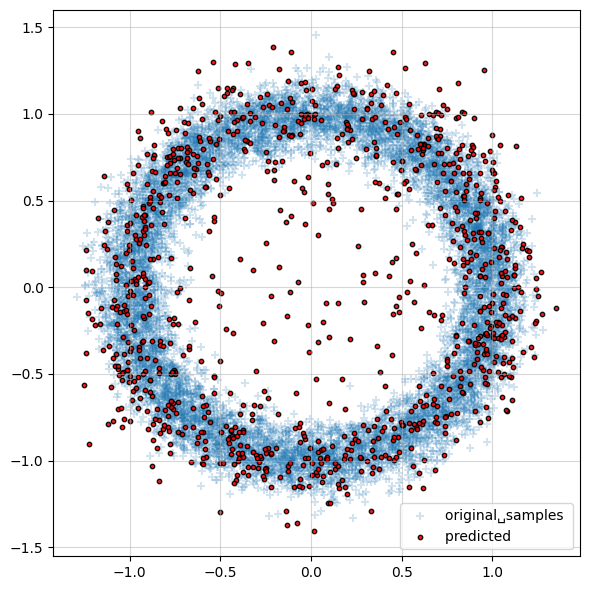

Epoch:␣ 250


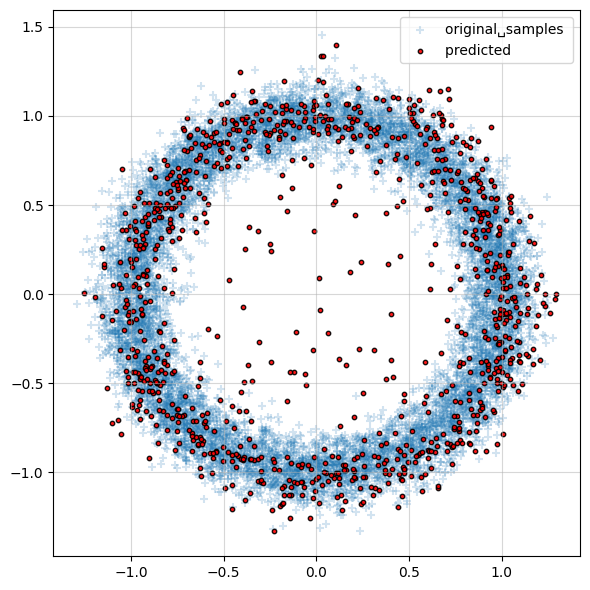

Epoch:␣ 300


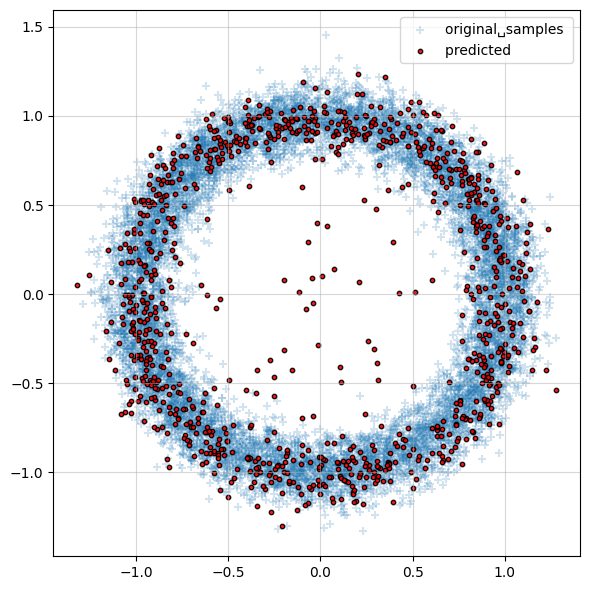

Epoch:␣ 350


In [6]:
noise_dim = 10
discriminator = Discriminator()
generator = Generator(noise_dim)

# Hyperparameters
lr_G = 1e-4#to choose
lr_D = 1e-4#to choose
n_epochs = 351#to choose
clip_value = 0.01 #to choose
n_critic = 10
batch_size = 64#to choose
optimizer_G = torch.optim.Adam(generator.parameters () ,
                               lr=lr_G , betas =(0.5, 0.9))
optimizer_D = torch.optim.Adam(discriminator.parameters () ,
                               lr=lr_D , betas =(0.5, 0.9))
dataloader = DataLoader(X_train , batch_size , shuffle=True) #data loader


for epoch in range(n_epochs):
    for i, x in enumerate(dataloader):
        x = x.type(torch.float32)
        # ---------------------
        # Train Discriminator
        # ---------------------
        optimizer_D.zero_grad ()
        # Sample noise for generator input
        z = torch.randn((x.shape[0],noise_dim))
        #print(z.shape)# to complete
        # Generate a batch of fake data
        fake_x = generator(z)# to complete
        # Compute loss for the discriminator
        #print(x.shape)
        loss_D = (-discriminator(x) + discriminator(fake_x)).mean()# to complete
        loss_D.backward () # backpropagation
        optimizer_D.step()
        # Clip weights of discriminator
        for p in discriminator.parameters ():
            p.data.clamp_(-clip_value , clip_value)
        # Train the generator every n_critic iterations
        if i % n_critic == 0:
            # -----------------
            # Train Generator
            # -----------------
            optimizer_G.zero_grad ()
            z = torch.randn((x.shape[0],noise_dim))
            fake_x = generator(z)# to complete
            loss_G = -discriminator(fake_x).mean()# to complete
            loss_G.backward ()
            optimizer_G.step()
        # Visualization of intermediate results
    if epoch % 50 == 0:
        print("Epoch:␣", epoch)
        generate_images(generator , noise_dim)

## Q7

We use a different caracterisation to inforce the lip condition.

Epoch:␣ 0


<ipython-input-5-c18b4a8bd520>:6: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_train[:, 0], X_train[:, 1], s=40, alpha =0.2,


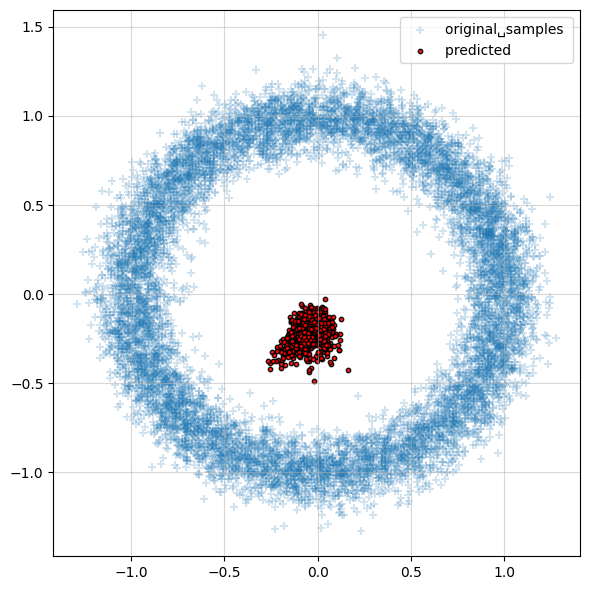

Epoch:␣ 50


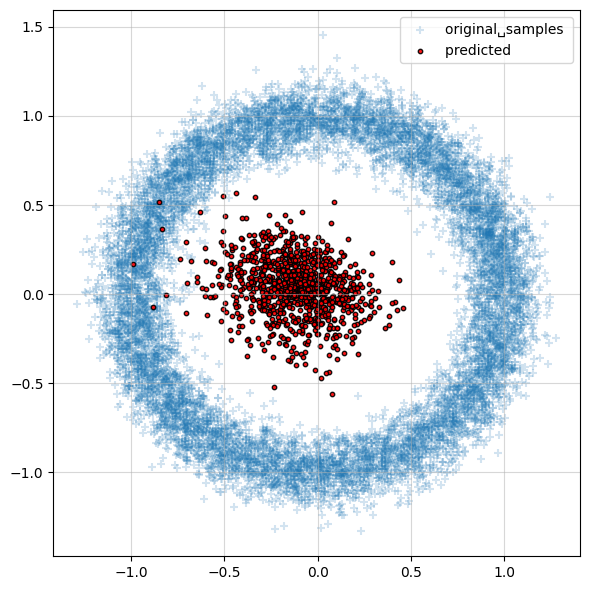

Epoch:␣ 100


Epoch:␣ 150


Epoch:␣ 200


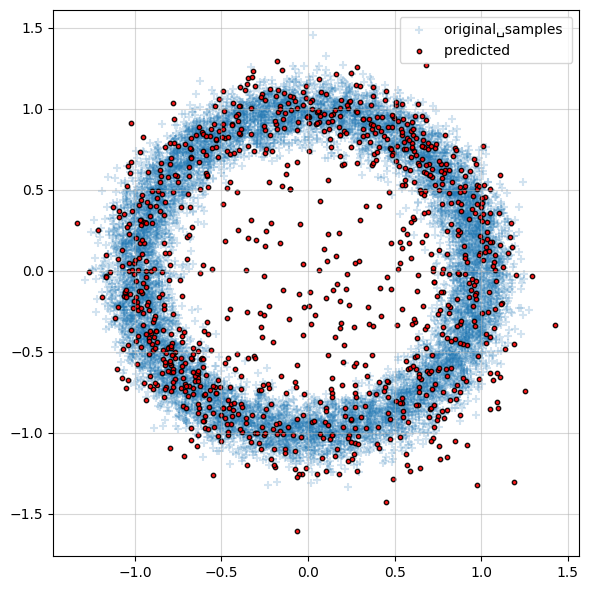

Epoch:␣ 250


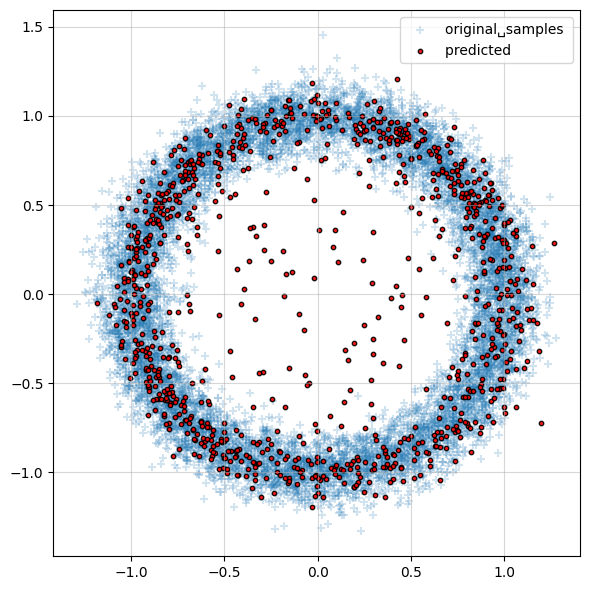

Epoch:␣ 300


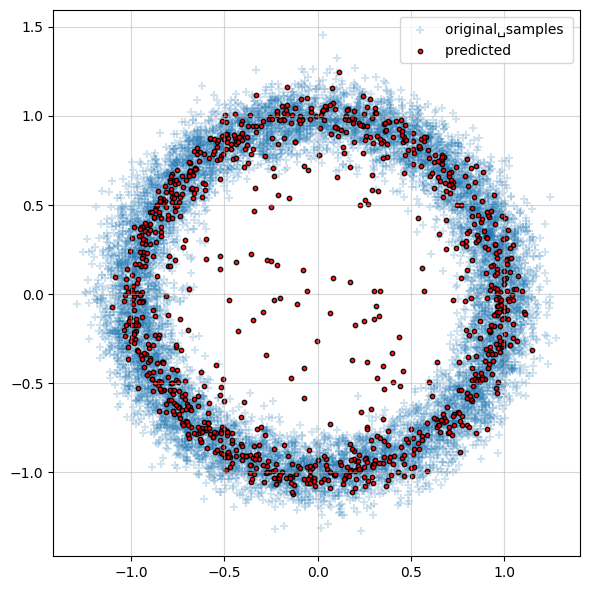

Epoch:␣ 350


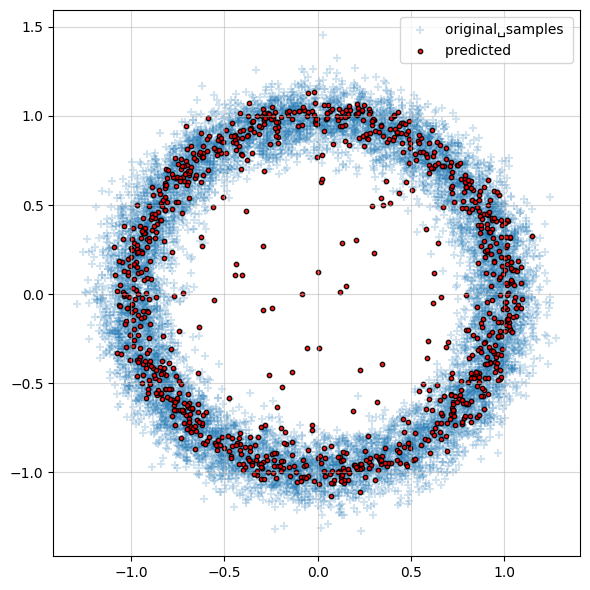

In [7]:
def compute_gradient_penalty(D, real_samples , fake_samples):
    # Random weight term for interpolation between real and fake samples
    alpha = torch.Tensor(np.random.random (( real_samples.size (0), 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples))
    d_interpolates = D(interpolates.requires_grad_(True))
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates ,
        inputs=interpolates ,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True ,
        retain_graph=True ,
        only_inputs=True ,
        )[0]
    return gradients

noise_dim = 10
discriminator = Discriminator()
generator = Generator(noise_dim)

# Hyperparameters
lr_G = 1e-4#to choose
lr_D = 1e-4#to choose
n_epochs = 351#to choose
n_critic = 10
batch_size = 64#to choose
optimizer_G = torch.optim.Adam(generator.parameters () ,
                               lr=lr_G , betas =(0.5, 0.9))
optimizer_D = torch.optim.Adam(discriminator.parameters () ,
                               lr=lr_D , betas =(0.5, 0.9))
dataloader = DataLoader(X_train , batch_size , shuffle=True) #data loader

l = 5
for epoch in range(n_epochs):
    for i, x in enumerate(dataloader):
        x = x.type(torch.float32)
        # ---------------------
        # Train Discriminator
        # ---------------------
        optimizer_D.zero_grad ()
        # Sample noise for generator input
        z = torch.randn((x.shape[0],noise_dim))
        #print(z.shape)# to complete
        # Generate a batch of fake data
        fake_x = generator(z)# to complete
        # Compute loss for the discriminator
        #print(x.shape)
        gp = compute_gradient_penalty(discriminator, x , fake_x)
        loss_D = (-discriminator(x) + discriminator(fake_x) + l * ((torch.norm(gp,dim=1)-1)**2)).mean()# to complete
        loss_D.backward () # backpropagation
        optimizer_D.step()
        # Train the generator every n_critic iterations
        if i % n_critic == 0:
            # -----------------
            # Train Generator
            # -----------------
            optimizer_G.zero_grad ()
            z = torch.randn((x.shape[0],noise_dim))
            fake_x = generator(z)# to complete
            loss_G = -discriminator(fake_x).mean()# to complete
            loss_G.backward ()
            optimizer_G.step()
        # Visualization of intermediate results
    if epoch % 50 == 0:
        print("Epoch:␣", epoch)
        generate_images(generator , noise_dim)

It's hard to find good Hyperparameters